In [2]:
import argparse
from collections import defaultdict, OrderedDict
import multiprocessing as mp
import os
import pickle
import re
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

from joblib import Parallel, delayed
import numpy as np
# import ray
# # use fewer CPUs so the OS doesn't run out of processes
# ray.init(num_cpus=16)
# import modin.pandas as pd
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

log = sys.stdout

## Global, general purpose functions

In [117]:
def pickle_dump(obj, path):
    with open(path, "wb") as outfile:
        pickle.dump(obj, outfile)
        
        
def pickle_load(path):
    with open(path, "rb") as infile:
        return pickle.load(infile)

## Loading data

### Setting up paths

In [134]:
root_data_dir = subprocess.check_output(
    "echo $MB_PROCESSED/vcf_to_ase/", 
    shell=True
).decode("UTF-8").strip()
sample_data_dir = "/".join([root_data_dir, "first_sample", "scRNA"])
counts_path = f"{sample_data_dir}/counts.csv"
counts_pkl_path = f"{sample_data_dir}/counts.pkl"
ref_genome_path = f"{root_data_dir}/genome.csv"
phasing_path = f"{root_data_dir}/phasing.csv"
clustering_path = f"{sample_data_dir}/sample1_scRNA_Seurat_clusters.tsv"

### Loading reference genome

In [39]:
genome_df = pd.read_csv(ref_genome_path)
assert np.all(np.isin(["CHROM", "START", "END", "GENE_ID"], genome_df.columns))
genome_df.head()

,CHROM,START,END,GENE_NAME,GENE_ID
0,1,11869,14412,DDX11L1,ENSG00000223972
1,1,14363,29806,WASH7P,ENSG00000227232
2,1,29554,31109,MIR1302-10,ENSG00000243485
3,1,34554,36081,FAM138A,ENSG00000237613
4,1,52473,54936,OR4G4P,ENSG00000268020


### Loading phasing information

In [40]:
phasing_df = pd.read_csv(phasing_path)
assert np.all(np.isin(["CHROM", "POS", "PHASE"], phasing_df.columns))
phasing_df.head()

,CHROM,POS,REF,ALT,PHASE
0,1,14464,A,T,1
1,1,14907,A,G,1
2,1,14976,G,A,1
3,1,15118,A,G,1
4,1,15211,T,G,1


### Loading read counts

In [220]:
def extract_barcodes(df):
    barcode_list = []
    barcode_pattern = r"(^(A|C|G|T)+-1)|(.*_(ad|dp)$)"
    for colname in df.columns:
        if re.match(barcode_pattern, colname) is not None:
            barcode_list.append(colname.split("_")[0])
    return np.unique(barcode_list)


def extract_snps(df):
    return np.array([
        f"{chrom},{pos}"
        for chrom, pos in 
        tqdm_notebook(df[["CHROM", "POS"]]\
                      .to_dense()\
                      .values\
                      .astype(np.int64), 
                      desc="extracting snps...")
    ])


def extract_counts(df, suffix="dp"):
    barcode_list = extract_barcodes(df)
    return df[[f"{barcode}_{suffix}" for barcode in barcode_list]]

In [7]:
%%time
if os.path.exists(raw_counts_pkl_path):
    # this is much faster than reading in chunks and concatenating those
    counts_df = pd.read_pickle(raw_counts_pkl_path)
else:
    chunksize = 2**14
    reader = pd.read_csv(raw_counts_path, 
                         dtype=np.float64, 
                         chunksize=chunksize)
    counts_df = pd.concat([chunk.to_sparse() for chunk in 
                        tqdm_notebook(
                            reader, 
                            desc=f"reading counts in chunks of size {chunksize}")
                       ])
counts_df.head()

CPU times: user 2.71 s, sys: 126 ms, total: 2.83 s
Wall time: 2.89 s


In [9]:
# ensure that non-phased SNPs were filtered out
assert np.all(np.isin(extract_snps(counts_df), 
                      extract_snps(phasing_df)))

### Loading clustering information

In [141]:
def extract_clusters(clustering_df):
    cluster_to_barcodes = {}
    for label, indices in clustering_df.groupby("LABEL").groups.items():
        cluster_to_barcodes[label] = clustering_df["BARCODE"][indices].values
    return cluster_to_barcodes

def extract_cluster_labels(clustering_df):
    return sorted(clustering_df.LABEL.unique())

clustering_df = pd.read_csv(clustering_path, sep='\t')
clustering_df.head()

cluster_label_col = "seurat_clusters"
barcode_col = "barcode"

clustering_df.rename(columns={cluster_label_col : "LABEL", 
                              barcode_col : "BARCODE"}, inplace=True)

assert np.all(clustering_df["BARCODE"].isin(extract_barcodes(counts_df)))

print("Cluster labels: ", extract_cluster_labels(clustering_df))

healthy_label_list = np.array([5, 7, 8, 9])
sick_label_list = np.setdiff1d(extract_cluster_labels(clustering_df), 
                               healthy_label_list)

Cluster labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Ensuring that alternative allele is maternal (0|1 in raw phasing results)

In [11]:
%%time
phasing_df = phasing_df.merge(counts_df[["CHROM", "POS"]].to_dense())
assert phasing_df.shape[0] == counts_df.shape[0]

if "PHASE" not in counts_df.columns:
    counts_df["PHASE"] = phasing_df.PHASE
    male_alt = counts_df.PHASE == 1

    for barcode in tqdm_notebook(extract_barcodes(counts_df), desc="cell_barcode"):
        ad = counts_df[f"{barcode}_ad"].to_dense()
        dp = counts_df[f"{barcode}_dp"].to_dense()
        ad[male_alt] = dp[male_alt] - ad[male_alt]
        counts_df[f"{barcode}_ad"] = ad.to_sparse()

counts_df.to_pickle(raw_counts_pkl_path)

CPU times: user 1.7 s, sys: 90.6 ms, total: 1.79 s
Wall time: 1.78 s


## Summarizing the dataset (for QC purposes)

In [201]:
def describe_raw_counts(counts_df, desc, clustering_df=None):
    """
    @counts_df — pd.SparseDataframe — raw counts
    @desc — description of counts_df
    @clustering_df — pd.DataFrame — assigns cluster label to each barcode
    
    This function summarizes the information about the raw counts.
    It computes such summary statistics as:
        1. Fraction of NaNs (per barcode)
        2. Average number of reads mapped to SNP (per barcode)
        3. Total number of reads (per barcode)
        4. Number of SNPs with at least one mapped read (per barcode). 
    If clustering information is provided, it also computes the distribution
    of reads across genome, taking cluster structure into account. 
    To do so, it adds up the reads mapping to each SNP (individually) for each 
    barcode in the cluster and then divides the sum by the cluster size.
    """
    
    print("{} columns, {} barcodes, {} SNPs".format(
        counts_df.shape[1],
        len(extract_barcodes(counts_df)),
        counts_df.shape[0]
    ))

    fig, axes = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True)
    fig.suptitle(desc)
    axes[0,0].set_title("Fraction of NaNs per cell");
    counts_df.isna().mean().hist(ax=axes[0,0]);

    axes[0,1].set_title("Reads per SNP (on average) per cell");
    extract_counts(counts_df, suffix="dp").mean().hist(ax=axes[0,1]);

    axes[1,0].set_title("Reads per barcode (in total)");
    extract_counts(counts_df, suffix="dp").sum().hist(ax=axes[1,0]);

    axes[1,1].set_title("SNPs with at least one mapped read (one point per cell)");
    (extract_counts(counts_df, suffix="dp") > 0).sum().hist(ax=axes[1,1]);
    fig.show()

    if clustering_df is not None:
        cluster_to_barcodes = extract_clusters(clustering_df)
        cluster_label_list = extract_cluster_labels(clustering_df)
        print("Cluster labels: ", cluster_label_list)

        n_clusters = len(cluster_label_list)
        grid_shape = (n_clusters // 2 + n_clusters % 2, 2)
        sns.set()
        fig, axes = plt.subplots(*grid_shape, figsize=(15,30), constrained_layout=True)
        fig.suptitle("Distribution of reads in the genome (per cluster, DP counts averaged within cluster)")
        for i, label in enumerate(tqdm_notebook(cluster_label_list, desc="processing clusters")):
            ax = axes[i // grid_shape[1], i % grid_shape[1]]
            ax.set_title(f"Cluster label: {label}")
            ax.set_xlabel("SNP id")
            ax.set_ylabel("total DP count")    
            dp_counts = np.zeros(counts_df.shape[0])
            for barcode in cluster_to_barcodes[label]:
                dp_counts = dp_counts + counts_df[f"{barcode}_dp"].to_dense().fillna(0).values
            dp_counts /= len(cluster_to_barcodes[label])
            ax.plot(dp_counts, label=label)
        fig.show()

13341 columns, 6669 barcodes, 240960 SNPs


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Cluster labels:  [0 1 2 3 4 5 6 7 8 9]


CPU times: user 2min 15s, sys: 28 s, total: 2min 43s
Wall time: 2min 45s


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


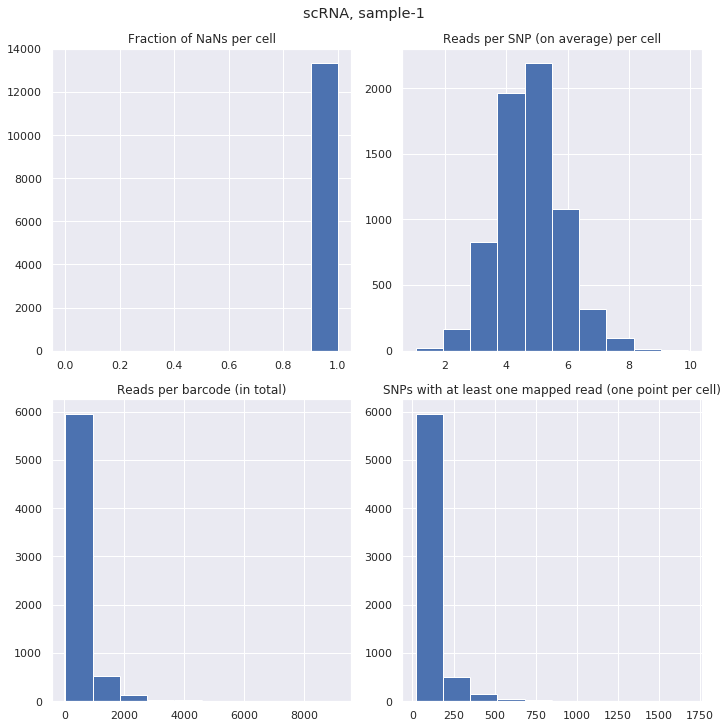

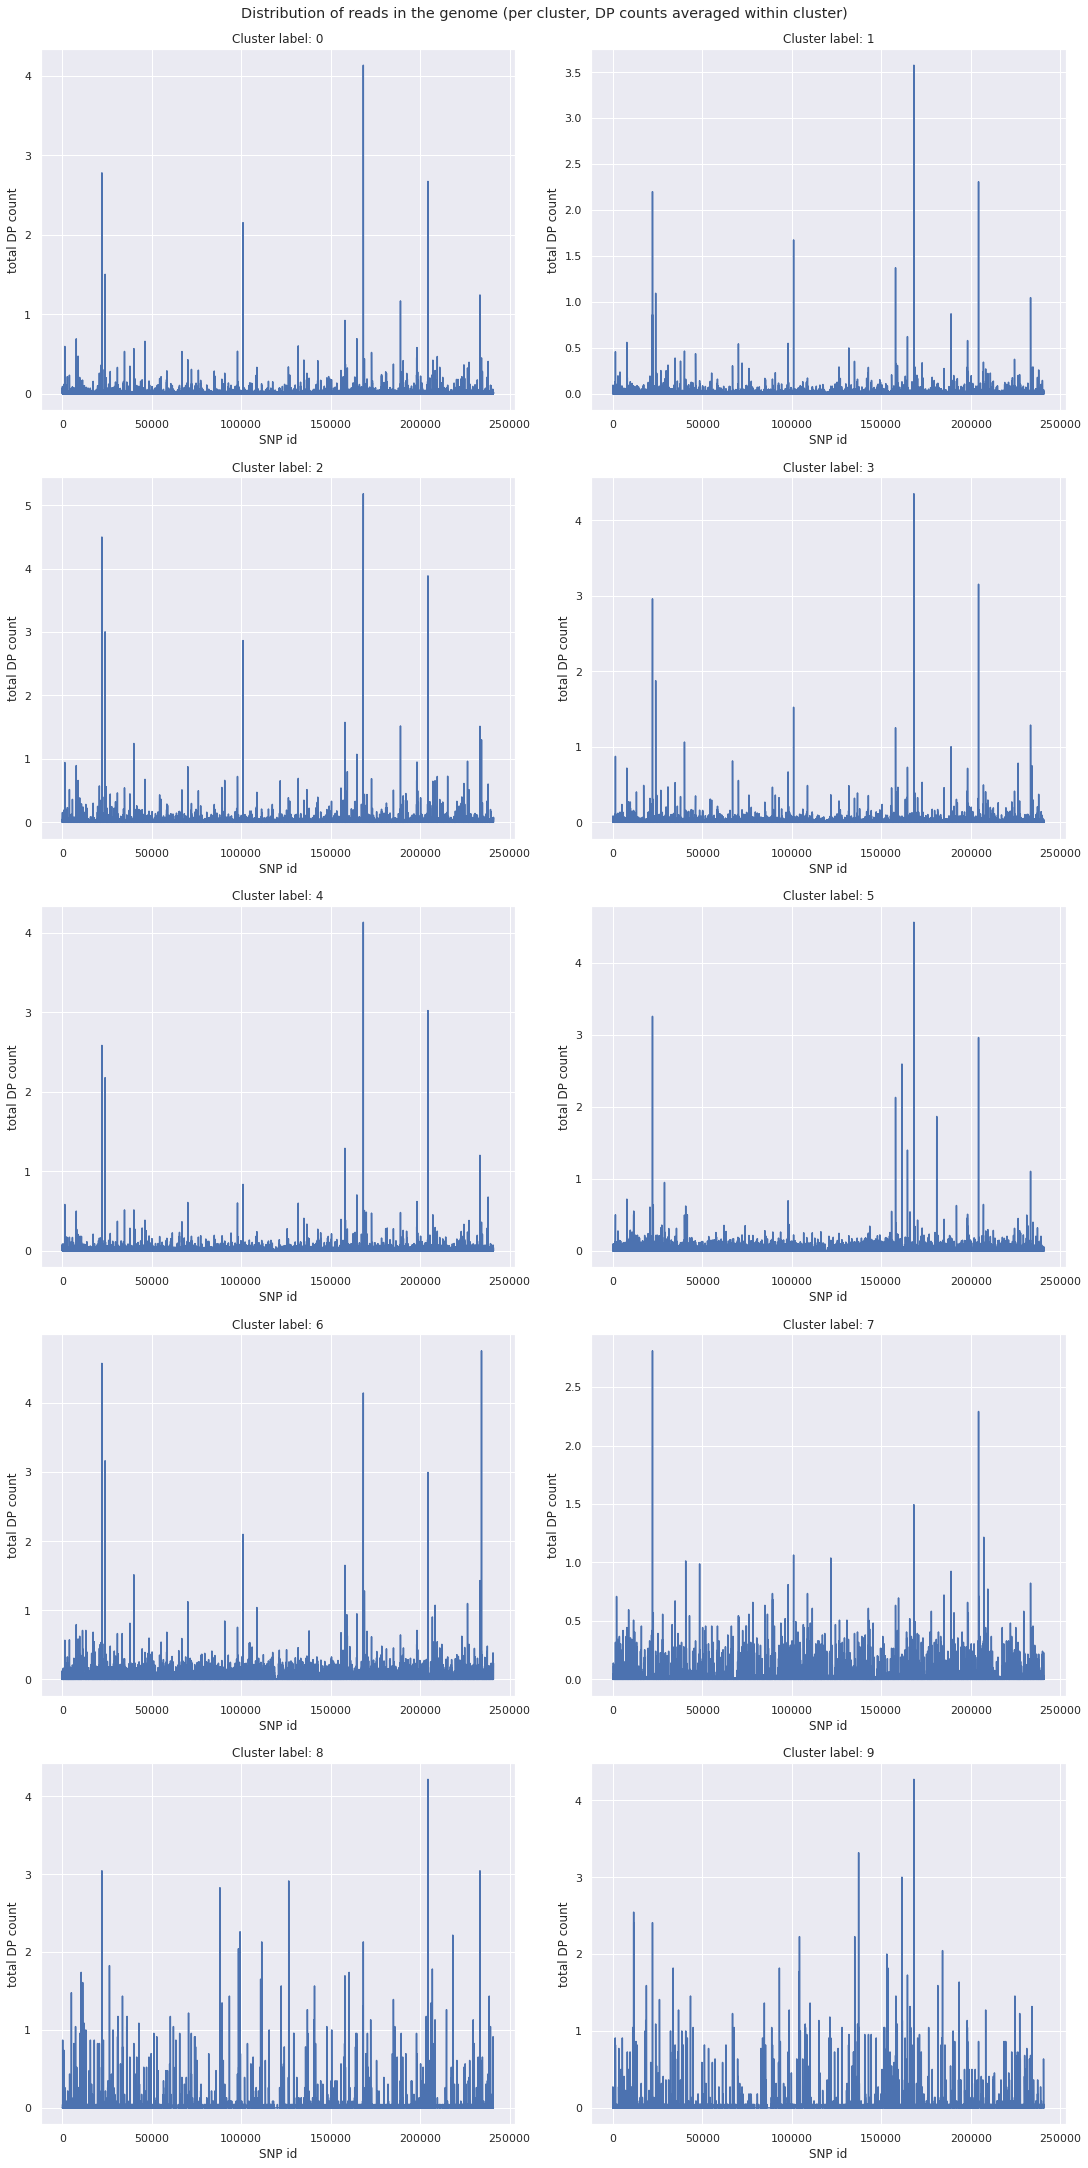

In [102]:
%%time
describe_raw_counts(сounts_df, "scRNA, sample-1", clustering_df)

## Mapping SNPs to genes (and the other way around)

In [76]:
counts_df = pd.read_pickle(raw_counts_pkl_path)
genome_df = pd.read_csv(ref_genome_path)
snp_df = counts_df[["CHROM", "POS"]].to_dense().astype(np.int64)

In [77]:
def extract_genes_on_chromosome(df):
    chrom_to_genes = {}
    for chrom in genome_df["CHROM"].value_counts().keys():
        chrom_to_genes[chrom] = genome_df[genome_df.CHROM == chrom]
    return chrom_to_genes

chrom_to_genes = extract_genes_on_chromosome(genome_df)

In [78]:
%%time

# Here gene coverage for each phased SNP is computed
# TODO: rewrite this using "bedtools intersect".
# This part doesn't scale well.

def map_snp_to_genes(snp_tuple):
    chrom, pos = snp_tuple
    # 1-based to 0-based 
    pos -= 1 # because CellCNP is 1-based, but .bed files are 0-based
    genes_on_chrom = chrom_to_genes[str(chrom)]
    mask = (genes_on_chrom.START <= pos) & (pos < genes_on_chrom.END)
    return ';'.join(genes_on_chrom[mask].GENE_ID)

pool = mp.Pool(4)
result = pool.map(map_snp_to_genes, 
                  tqdm_notebook(snp_df.values))
pool.close()
pool.join()

CPU times: user 3.26 s, sys: 1.46 s, total: 4.71 s
Wall time: 2min 11s


In [79]:
""" Here the raw results computed in parallel are parsed """

snp_to_genes, gene_to_snps = {}, OrderedDict()

# This way we ensure proper gene ordering
for gene_id in genome_df.GENE_ID:
    gene_to_snps[gene_id] = []

for i, row in tqdm_notebook(enumerate(snp_df.values), "mapping SNPs to genes"):
    chrom, pos = row
    snp = f"{chrom},{pos}"
    snp_to_genes[snp] = result[i].split(";") if result[i] else []
    for gene in snp_to_genes[snp]:
        gene_to_snps[gene].append(snp)

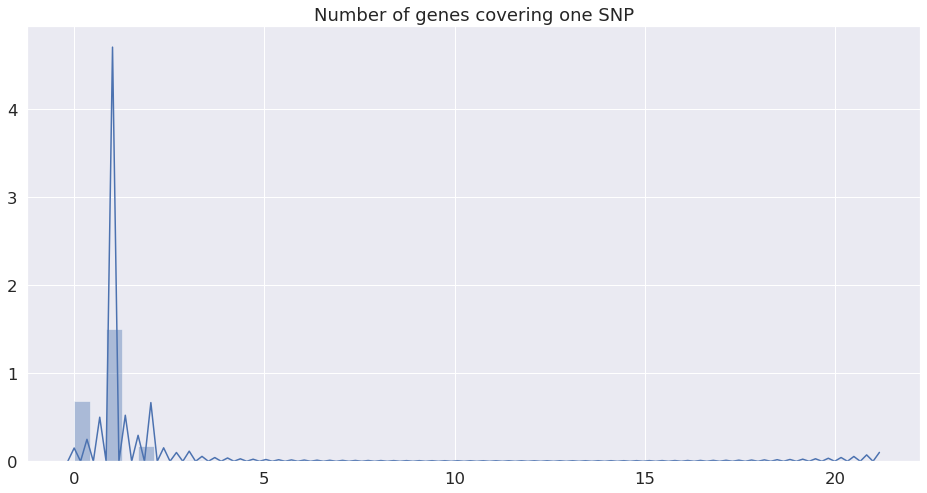

In [80]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.title("Number of genes covering one SNP")
sns.distplot([len(gene_list) for gene_list in snp_to_genes.values()]);

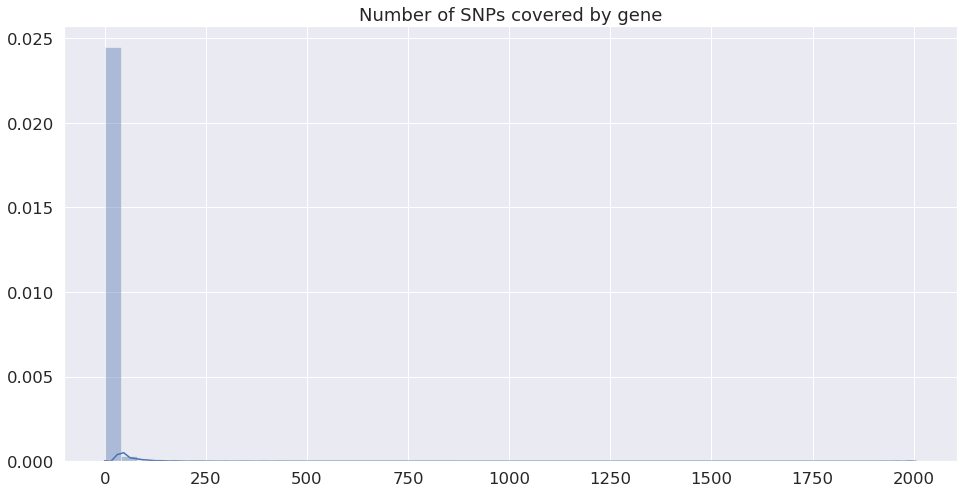

In [81]:
plt.figure(figsize=(16,8))
plt.title("Number of SNPs covered by gene")
sns.distplot([len(snp_list) for snp_list in gene_to_snps.values()]);

In [82]:
pickle_dump(snp_to_genes, f"{sample_data_dir}/snp_to_genes.pkl")
pickle_dump(gene_to_snps, f"{sample_data_dir}/gene_to_snps.pkl")

## Aggregating read counts over genes

In [114]:
gene_to_snps = pickle_load(f"{sample_data_dir}/gene_to_snps.pkl")
snp_to_genes = pickle_load(f"{sample_data_dir}/snp_to_genes.pkl")
gene_counts_df = pd.SparseDataFrame()

In [115]:
snp_to_idx = {snp : i for i, snp in 
              tqdm_notebook(enumerate(extract_snps(counts_df)), 
                            "processing snps...")}

In [117]:
%%time

gene_to_snp_ids = {gene : np.fromiter((snp_to_idx[snp] for snp in snp_list), dtype=int) 
                   for gene, snp_list in tqdm_notebook(gene_to_snps.items(), 
                                                       desc="mapping refinement")}

def extract_gene_counts(barcode):
    gene_to_ad, gene_to_dp = [], []
    ad = counts_df[f"{barcode}_ad"].to_dense().values
    dp = counts_df[f"{barcode}_dp"].to_dense().values
    # gene_to_snps is an OrderedDict, so we can guarantee
    # that all the genes are processed in a correct order
    for gene in gene_to_snps.keys():
        snp_ids = gene_to_snp_ids[gene]
        if len(snp_ids) > 0:
            gene_to_ad.append(ad[snp_ids].sum())
            gene_to_dp.append(dp[snp_ids].sum())
    return pd.SparseDataFrame({f"{barcode}_ad" : gene_to_ad, 
                               f"{barcode}_dp" : gene_to_dp})

with mp.Pool(8) as pool:
    result_list = pool.map(
        extract_gene_counts, 
        tqdm_notebook(extract_barcodes(counts_df), 
                      desc="cell_barcode processing")
    )
    
gene_counts_df = pd.concat(result_list, axis=1)

CPU times: user 13.4 s, sys: 13.2 s, total: 26.6 s
Wall time: 4min 22s


In [118]:
gene_counts_df.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 14706 entries, 0 to 14705
Columns: 13338 entries, AAACCTGCACATCCAA-1_ad to TTTGTCATCCCAAGAT-1_dp
dtypes: Sparse[float64, nan](13338)
memory usage: 650.2 KB


In [119]:
gene_counts_df.shape

(14706, 13338)

In [120]:
genome_df.head()

,CHROM,START,END,GENE_NAME,GENE_ID
0,1,11869,14412,DDX11L1,ENSG00000223972
1,1,14363,29806,WASH7P,ENSG00000227232
2,1,29554,31109,MIR1302-10,ENSG00000243485
3,1,34554,36081,FAM138A,ENSG00000237613
4,1,52473,54936,OR4G4P,ENSG00000268020


In [122]:
gene_counts_df.insert(0, "GENE_ID", [gene for gene, snp_list 
                                     in gene_to_snps.items() 
                                     if len(snp_list) > 0])

In [123]:
gene_counts_df.head()

,GENE_ID,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,ENSG00000227232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000238009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000239906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000228463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000230021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
true_gene_ids = np.hstack(np.where(genome_df.GENE_ID == gene_id) 
                          for gene_id in tqdm_notebook(gene_counts_df.GENE_ID))

In [125]:
# assert correct (strictly ascending) gene ordering in gene_counts_df
assert np.all(np.diff(true_gene_ids) > 0) 

In [126]:
gene_counts_df.to_pickle(f"{sample_data_dir}/gene_counts.pkl")

## Getting an ASE matrix

In [177]:
def compute_ase(counts_df, barcode_list):
    ase_df = pd.concat([
        pd.DataFrame({
            f"{barcode}" 
            : counts_df[f"{barcode}_ad"].to_dense().fillna(0) 
            / counts_df[f"{barcode}_dp"].to_dense().fillna(0)
        }) 
        for barcode in tqdm_notebook(barcode_list, desc="barcode")], 
        axis=1
    )
    return ase_df

In [191]:
%%time
gene_counts_df = pd.read_pickle(f"{sample_data_dir}/gene_counts.pkl")
ase_df = compute_ase(gene_counts_df, extract_barcodes(gene_counts_df))
ase_df["GENE_ID"] = gene_counts_df["GENE_ID"]
ase_df.to_pickle(f"{sample_data_dir}/ase.pkl")
ase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14706 entries, 0 to 14705
Columns: 6670 entries, AAACCTGCACATCCAA-1 to GENE_ID
dtypes: Sparse[object, nan](1), float64(6669)
memory usage: 748.4 MB
CPU times: user 17.7 s, sys: 20.5 s, total: 38.2 s
Wall time: 54.9 s


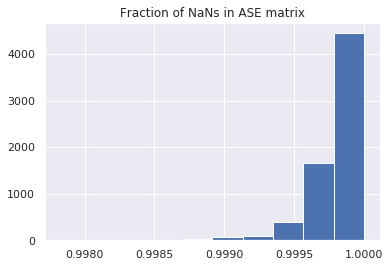

In [192]:
plt.title("Fraction of NaNs in ASE matrix")
ase_df.drop(columns="GENE_ID").isna().mean().hist()

## Aggregating by cell barcode

Take read counts and clustering info as an input.
Add up the counts in each cluster. 

In [160]:
def aggregate_by_cells(counts_df, clustering_df):
    assert np.all(np.isin(clustering_df.BARCODE, 
                          extract_barcodes(counts_df)))
    
    cluster_to_barcodes = extract_clusters(clustering_df)
    cluster_labels = extract_cluster_labels(clustering_df)
    
    result_df = pd.DataFrame()
    
    for label in tqdm_notebook(cluster_labels, desc="cluster label"):
        for suffix in ["ad", "dp"]:
            result_df[f"{label}_{suffix}"] = np.zeros(counts_df.shape[0])    
            for barcode in cluster_to_barcodes[label]:
                result_df[f"{label}_{suffix}"] += counts_df[f"{barcode}_{suffix}"].to_dense().fillna(0)
    
    return result_df

In [163]:
gene_counts_df = pd.read_pickle(f"{sample_data_dir}/gene_counts.pkl")
clustered_df = aggregate_by_cells(gene_counts_df, clustering_df)
clustered_df.to_pickle(f"{sample_data_dir}/clustered_gene_counts.pkl")
clustered_df.head()

,0_ad,0_dp,1_ad,1_dp,2_ad,2_dp,3_ad,3_dp,4_ad,4_dp,5_ad,5_dp,6_ad,6_dp,7_ad,7_dp,8_ad,8_dp,9_ad,9_dp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


20 columns, 10 barcodes, 14706 SNPs


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


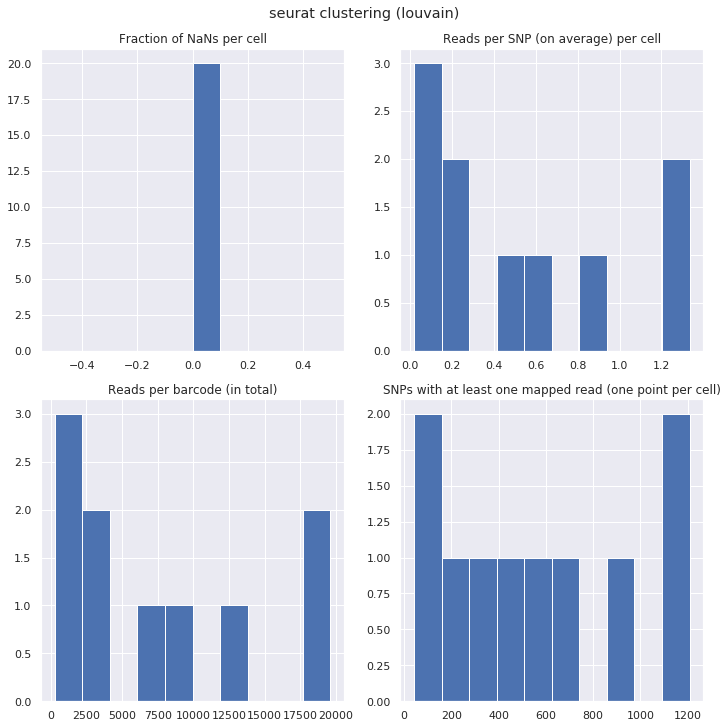

In [222]:
describe_raw_counts(clustered_df, "seurat clustering (louvain)")

In [183]:
clustered_ase_df = compute_ase(clustered_df, 
                               extract_cluster_labels(clustering_df))
clustered_ase_df.shape

(14706, 10)

In [208]:
extract_barcodes(counts_df)

array(['AAACCTGCACATCCAA-1', 'AAACCTGCACTAGTAC-1', 'AAACCTGCATCATCCC-1',
       ..., 'TTTGTCAGTTAAAGAC-1', 'TTTGTCATCATCGGAT-1',
       'TTTGTCATCCCAAGAT-1'], dtype='<U18')

<Figure size 1440x2160 with 0 Axes>

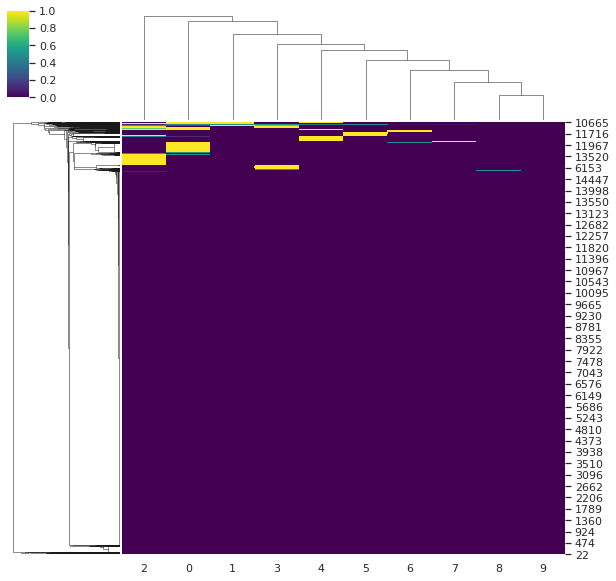

In [193]:
# cures "RecursionError"
sys.setrecursionlimit(15000)

try: 
    plt.figure(figsize=(20,30))
    sns.clustermap(
        clustered_ase_df\
    #     .drop(columns=["GENE"])\
        .fillna(value=0)\
        .astype(np.float64)\
        .values,
        cmap="viridis"
    );
except RecursionError:
    print("RecursionError: increase stack size")

In [194]:
clustered_ase_df.to_pickle(f"{sample_data_dir}/clustered_ase_df.pkl")

# HERE THE SECOND NOTEBOOK BEGINS

## Assigning labels via ASE profiles

In [105]:
scDNA_dir = f"{root_data_dir}/first_sample/scDNA"
scRNA_dir = f"{root_data_dir}/first_sample/scRNA"

In [106]:
scDNA_ase_df = pd.read_pickle(f"{scDNA_dir}/ase.pkl").to_dense()
scRNA_counts_df = pd.read_pickle(f"{scRNA_dir}/gene_counts.pkl").to_dense()

In [107]:
scDNA_ase_df.head()

,GENE_ID,AAACCTGCACGACTAT-1,AAACCTGTCTTGCGAA-1,AAACGGGAGTGTTGAA-1,AAACGGGGTACTCACA-1,AAAGCAAAGCTGGTCC-1,AAAGCAAAGGCCATAG-1,AACACGTCACTGCGCA-1,AACACGTTCGATAGTC-1,AACCATGGTAAGTGTA-1,...,TTCTACACACCCGTGA-1,TTCTCAAAGAAAGCTT-1,TTCTCCTCATCTCACC-1,TTCTCCTTCAAGCCAT-1,TTCTTAGAGTAGTGCG-1,TTGAACGCAGCGATGA-1,TTGCGTCCAACGGCTC-1,TTGGAACGTTCTGTCC-1,TTTATGCCATGTTTCT-1,TTTCCTCGTGATCCTA-1
0,ENSG00000223972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000227232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000243485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000237613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000268020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN


In [108]:
scRNA_counts_df.head()

,GENE_ID,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,...,TTTGTCAGTGCGCTTG-1_ad,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp
0,ENSG00000227232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000238009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000239906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000228463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000230021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
cnv_tsv = f"{scDNA_dir}/scores.tsv"

In [111]:
scDNA_cnv_df.sort_values(by="loading_scores", ascending=False, inplace=True)

In [112]:
scDNA_cnv_df.head()

,gene_id,1,2,3,loading_scores
34507,ENSG00000236854,17.0,22.5,39.0,0.048392
30567,ENSG00000230964,9.0,9.5,17.0,0.017581
48353,ENSG00000261600,9.0,9.5,17.0,0.017581
8430,ENSG00000143429,9.0,9.5,17.0,0.017538
32589,ENSG00000233991,9.0,9.5,17.0,0.017466


In [110]:
scDNA_cnv_df = pd.read_csv(cnv_tsv, sep='\t')

In [54]:
gene_ordering = {gene : i for i, gene in enumerate(scDNA_cnv_df.gene_id)}
scRNA_counts_df["GENE_RANK"] = [gene_ordering.get(gene) for gene in scRNA_counts_df.GENE]
scDNA_ase_df["GENE_RANK"] = [gene_ordering.get(gene) for gene in scDNA_ase_df.GENE]
scRNA_counts_df.head()

,GENE,AAACCTGCACATCCAA-1_ad,AAACCTGCACATCCAA-1_dp,AAACCTGCACTAGTAC-1_ad,AAACCTGCACTAGTAC-1_dp,AAACCTGCATCATCCC-1_ad,AAACCTGCATCATCCC-1_dp,AAACCTGGTAGCGATG-1_ad,AAACCTGGTAGCGATG-1_dp,AAACCTGGTAGCTCCG-1_ad,...,TTTGTCAGTGCGCTTG-1_dp,TTTGTCAGTGTTTGTG-1_ad,TTTGTCAGTGTTTGTG-1_dp,TTTGTCAGTTAAAGAC-1_ad,TTTGTCAGTTAAAGAC-1_dp,TTTGTCATCATCGGAT-1_ad,TTTGTCATCATCGGAT-1_dp,TTTGTCATCCCAAGAT-1_ad,TTTGTCATCCCAAGAT-1_dp,GENE_RANK
0,ENSG00000227232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,ENSG00000238009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,ENSG00000239906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,ENSG00000228463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,ENSG00000230021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [55]:
%%time
barcode_list = []
barcode_pattern = r"^(A|G|C|T)+-1_[ad|dp]"
for colname in tqdm_notebook(scRNA_counts_df.columns, 
                             desc="cell barcode"):
    if re.match(barcode_pattern, colname) is not None:
        barcode_list.append(colname.split("_")[0])
barcode_list = np.unique(barcode_list)


CPU times: user 133 ms, sys: 60.1 ms, total: 193 ms
Wall time: 183 ms


In [56]:
scDNA_ase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23037 entries, 0 to 23036
Data columns (total 5 columns):
GENE         -23037 non-null Sparse[object, nan]
1            -23076 non-null Sparse[float64, nan]
2            -25655 non-null Sparse[float64, nan]
3            -23486 non-null Sparse[float64, nan]
GENE_RANK    -23785 non-null float64
dtypes: Sparse[float64, nan](3), Sparse[object, nan](1), float64(1)
memory usage: 896.2 KB


In [57]:
scDNA_genes = scDNA_ase_df.GENE
scRNA_genes = scRNA_counts_df.GENE
common_genes = set(scDNA_genes) & set(scRNA_genes)
scDNA_ase_df = scDNA_ase_df[scDNA_ase_df.GENE.isin(common_genes)]
scRNA_counts_df = scRNA_counts_df[scRNA_counts_df.GENE.isin(common_genes)]

In [58]:
scDNA_ase_df.shape

(14497, 5)

In [59]:
scRNA_counts_df.shape

(14497, 13340)

In [60]:
scDNA_ase_df = scDNA_ase_df.sort_values(by="GENE_RANK", ascending=False).iloc[:1000, :]
scDNA_ase_df.sort_index(inplace=True)
scRNA_counts_df = scRNA_counts_df.sort_values(by="GENE_RANK", ascending=False).iloc[:1000, :]
scRNA_counts_df.sort_index(inplace=True)

<Figure size 1440x2160 with 0 Axes>

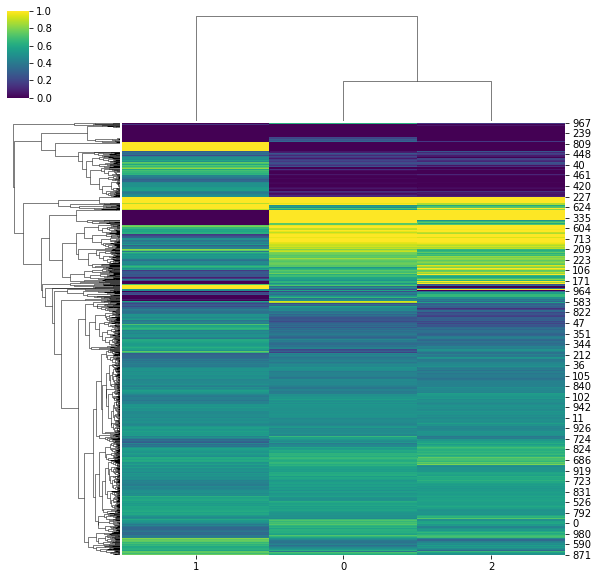

In [61]:
plt.figure(figsize=(20,30))
sns.clustermap(
    scDNA_ase_df\
    .drop(columns=["GENE", "GENE_RANK"])\
    .fillna(value=0)\
    .astype(np.float32)\
    .values,
    cmap="viridis"
);

In [77]:
scDNA_ase_df.drop(columns=["GENE_RANK"], inplace=True)
scRNA_counts_df.drop(columns=["GENE_RANK"], inplace=True)

In [172]:
labels = []

def assign_label(barcode):
    loglikelihood = []
    for cluster_label in scDNA_ase_df.columns[1:]:
        Nm = cell_gene_counts[f"cluster_{barcode}_ad"]
        Np = cell_gene_counts[f"cluster_{barcode}_dp"] - Nm
        profile = scDNA_ase_df[cluster_label].values
        loglikelihood.append(
            (((profile > 0) | (Nm == 0)) * Nm * np.log(profile)).dropna().values.sum()
            + (((profile < 1) | (Np == 0)) * Np * np.log(1 - profile)).dropna().values.sum()
        )
    print(loglikelihood)
    return np.nanargmax(loglikelihood)

pool = mp.Pool(1)
labels = pool.map(assign_label, 
                  tqdm_notebook(cluster_label_list, desc="barcode processing"))
pool.close()
pool.join()

labels = np.array(labels)

# for barcode in tqdm_notebook(barcode_list, desc="barcode processing"):
#     loglikelihood = []
#     for cluster_label in scDNA_ase_df.columns[1:]:
#         Nm = scRNA_counts_df[f"{barcode}_ad"]
#         Np = scRNA_counts_df[f"{barcode}_dp"] - Nm
#         profile = scDNA_ase_df[cluster_label].values
#         loglikelihood.append(
#             (((profile > 0) | (Nm == 0)) * Nm * np.log(profile)).dropna().values.sum()
#             + (((profile < 1) | (Np == 0)) * Np * np.log(1 - profile)).dropna().values.sum()
#         )
#     labels.append(np.nanargmax(loglikelihood))

/home/v390v/.conda/envs/vivanov/lib/python3.7/site-packages/pandas/core/arrays/sparse.py:1625: RuntimeWarning: divide by zero encountered in log
  sp_values = getattr(ufunc, method)(self.sp_values, **kwargs)


[-22835.479426154343, -22103.901674231704, -21769.054947510347]
[-15080.903505825801, -14377.142397252934, -14125.839328634353]
[-21887.287173786088, -21680.36769190173, -21404.528404531346]

[-10522.266129427826, -10401.98955179541, -10185.347631876582]
[-7769.649829775299, -7498.479849656726, -7552.285272324354]
[-8343.46704304171, -7635.147075048997, -7909.140940262025]
[-3828.435708506069, -3411.7083817607004, -3374.252308647568]
[-998.8369062895177, -1027.501309681965, -989.0477012673637]
[-543.8997347998345, -526.3713364327339, -541.968040893328]
[-401.3474039551726, -326.16483203158515, -349.02092722547263]


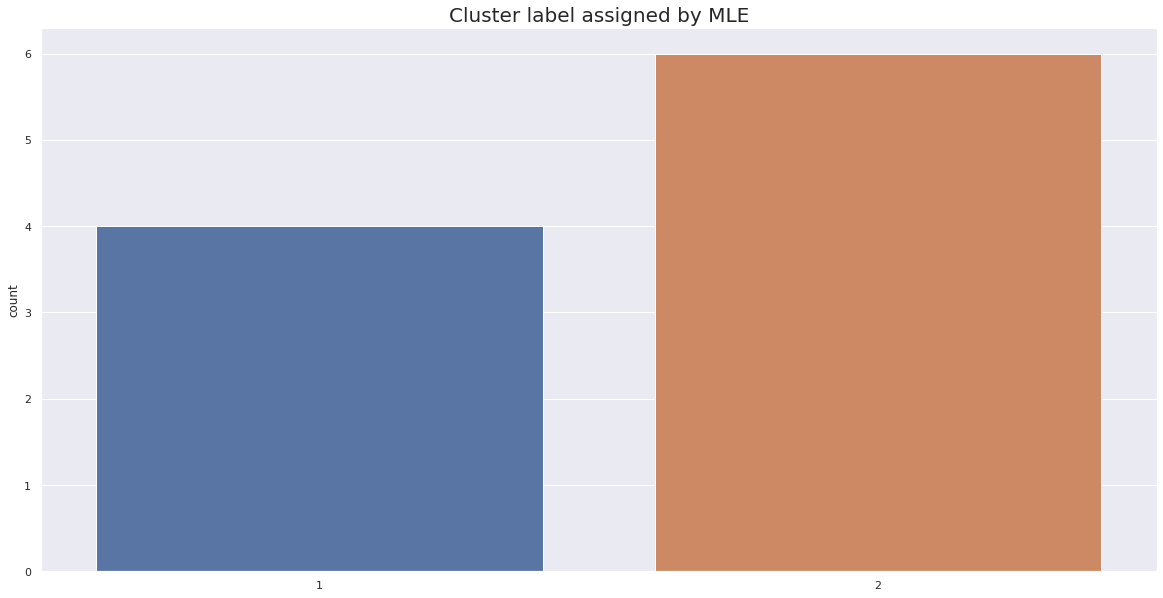

In [173]:
sns.set()
plt.figure(figsize=(20,10))
plt.title("Cluster label assigned by MLE", fontsize=20)
sns.countplot(labels)

In [181]:
ok_mle = labels == 1
ok_seurat = np.isin(np.array(cluster_label_list), [5,7,8,9])
pd.DataFrame(np.column_stack((ok_mle, ok_seurat)), 
             columns=["MLE", "seurat"])

,MLE,seurat
0,False,False
1,False,False
2,False,False
3,False,False
4,True,False
5,True,True
6,False,False
7,False,True
8,True,True
9,True,True


In [182]:
from sklearn.metrics import classification_report

print(classification_report(ok_seurat, ok_mle)) 

              precision    recall  f1-score   support

       False       0.83      0.83      0.83         6
        True       0.75      0.75      0.75         4

    accuracy                           0.80        10
   macro avg       0.79      0.79      0.79        10
weighted avg       0.80      0.80      0.80        10



In [81]:
tsne_tsv = "/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/single_cell_integration_dna_rna/scrna_vs_scdna/inputs/sample1_scRNA_Seurat_clusters.tsv"
tsne_df = pd.read_csv(tsne_tsv, sep='\t')
tsne_df.head()

,barcode,seurat_clusters,tSNE_1,tSNE_2
0,AAACCTGCACATCCAA-1,1,-12.448108,27.412456
1,AAACCTGCACTAGTAC-1,0,9.738823,11.845293
2,AAACCTGCATCATCCC-1,2,7.208576,-9.511222
3,AAACCTGGTAGCTCCG-1,1,-20.766361,18.106085
4,AAACCTGGTCTAAACC-1,2,5.619219,-12.530333


In [83]:
tsne_df.shape

(6126, 4)

In [96]:
len(barcode_list)

6669

In [95]:
pd.DataFrame(np.setdiff1d(barcode_list, tsne_df.barcode), 
             columns=["missing_barcode"]).to_csv("scRNA/missing_barcodes.tsv")

In [109]:
filtered_labels = labels[np.isin(barcode_list, tsne_df.barcode, assume_unique=True)]
tsne_df["mle_clusters"] = filtered_labels

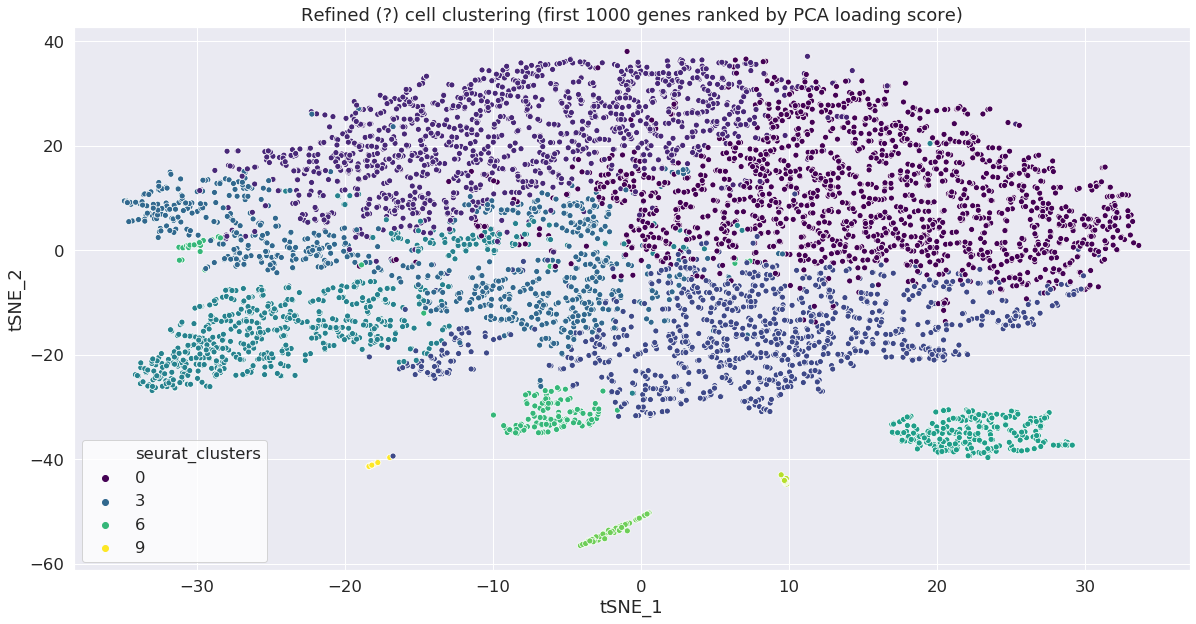

In [115]:
sns.set(font_scale=1.5);
plt.figure(figsize=(20,10))
plt.title("Refined (?) cell clustering (first 1000 genes ranked by PCA loading score)")
sns.scatterplot(x="tSNE_1", y="tSNE_2", hue="seurat_clusters", data=tsne_df, palette="viridis");
plt.legend().get_frame().set_facecolor("white");

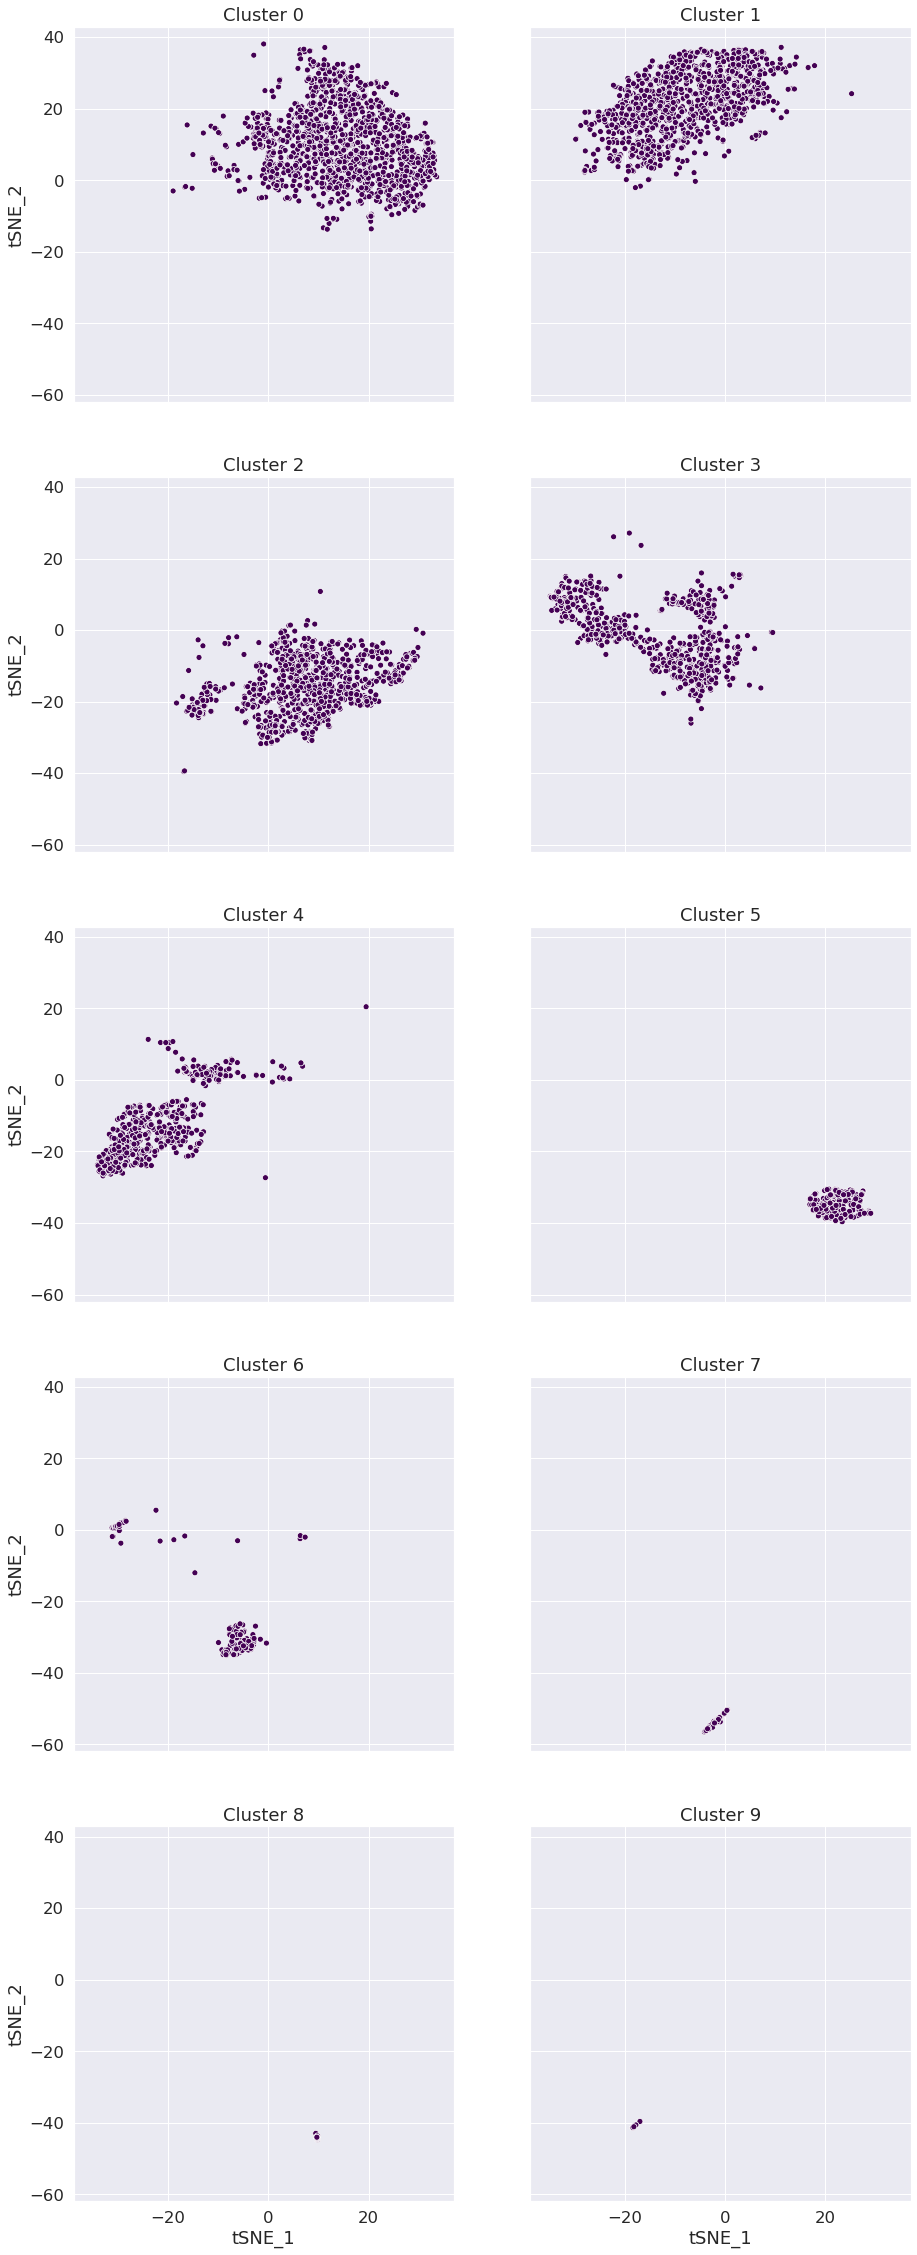

In [167]:
sns.set(font_scale=1.5);
fig, axes = plt.subplots(5, 2, figsize=(15,40), sharex=True, sharey=True)
for i in range(10):
    y, x = i//2, i%2
    sns.scatterplot(x="tSNE_1", y="tSNE_2", hue="seurat_clusters", 
                    data=tsne_df[tsne_df.seurat_clusters == i], 
                    palette="", ax=axes[y, x]);
    axes[y, x].set_title(f"Cluster {i}")
    axes[y, x].get_legend().remove()
#     axes[i//2, i%2].legend().get_frame().set_facecolor("white");

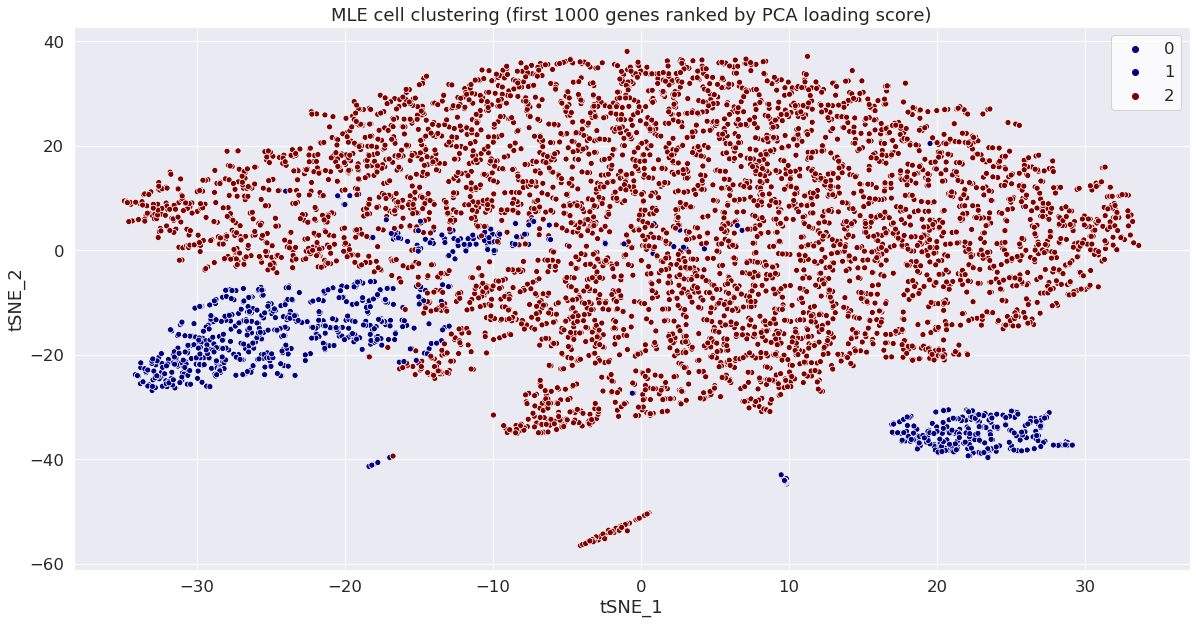

In [186]:
sns.set(font_scale=1.5);
plt.figure(figsize=(20,10))

true_labels = [labels[scl] for scl in tsne_df["seurat_clusters"]]
    
plt.title("MLE cell clustering (first 1000 genes ranked by PCA loading score)")

sns.scatterplot(x="tSNE_1", y="tSNE_2", hue=true_labels, data=tsne_df, palette="jet");
plt.legend().get_frame().set_facecolor("white");

In [80]:
labels_df = pd.DataFrame(np.column_stack((barcode_list, labels)), 
                         columns=["barcode", "cluster"])
labels_df.to_csv("scRNA/labels_26_07_top_1k_genes.tsv", sep='\t')